# Quadrature Encoder Example with VCD

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pioemu import conditions, emulate, State
from adafruit_pioasm import Program
from collections import deque
from vcdvcd import VCDVCD

## Introduction

This notebook demonstrates the emulation of a PIO program for the Raspberry Pi Foundation's RP2040 Microcontroller. Unique in this example is the use of pre-captured input (a value change dump file) for providing the input source. This shows that you can use real-world data captures in your simulation to verify functionality of your program.

## PIO Program

The program below counts the position of a quadrature encoder

Try changing it and observe the results!

In [2]:
qdec = '''
.program quadrature_decoder
   set x, 0
.wrap_target
public wait_lo:
    in x 32
    push noblock
    wait 0 pin 1
    jmp pin inc2
    jmp x-- wait_hi
    jmp wait_hi
inc2:
    mov x, !x
    jmp x-- inc3
inc3:
    mov x, !x
public wait_hi:
    in x 32
    push noblock
    wait 1 pin 1
    jmp pin dec1
    mov x, !x
    jmp x-- inc1
inc1:
    mov x, !x
    jmp wait_lo
dec1:
    jmp x-- wait_lo

.wrap
'''

asm = Program(qdec)

program = asm.assembled

## Emulation

In [3]:
class Vcd:
    def __init__(self, fname:str, clkrate:float = 1):
        self.d = VCDVCD(fname).data
        self.clkrate = clkrate
    def get(self, state:State) -> int:
        clk = int(state.clock * self.clkrate)
        accum = 0
        for k in reversed(list(self.d.keys())):
            accum <<= 1
            accum |= int(self.d[k][clk])
        return accum


v = Vcd('qenc.vcd', 100)

init = State(pin_directions=0x00, clock=0) #You can change the initial clock value to adjust the starting point in the VCD file

trace = [
    (state.clock, state.pin_values, state.program_counter, state.receive_fifo.pop() if state.receive_fifo else None)
    for _, state in emulate(program, 
                    stop_when=conditions.clock_cycles_reached(10000),
                    initial_state = init,
                    input_source=v.get,
                    wrap_target=asm.pio_kwargs['wrap_target'],
                    wrap_top=asm.pio_kwargs['wrap'],
                   )
]

## Output on Pin GP0

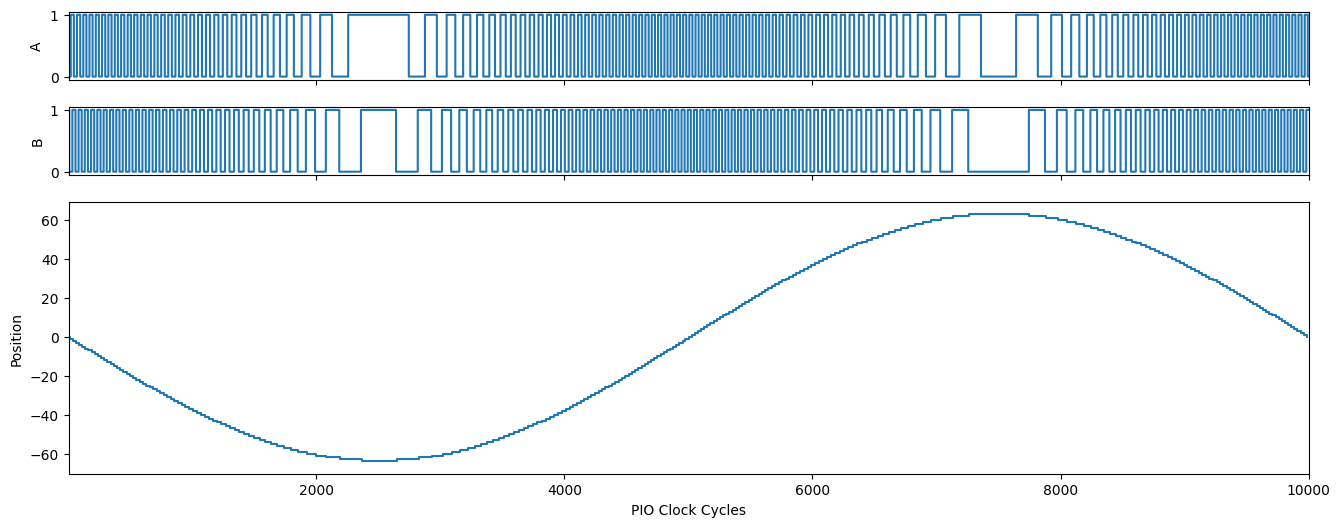

In [4]:
t = [x[0] for x in trace]

fig, axes = plt.subplots(3,1,sharex=True,sharey=False, figsize=(16,6), height_ratios=[1,1,4])
axes[0].step(t,  [1 if x[1]&1 else 0 for x in trace])
axes[0].set_ylabel('A')
axes[0].set_yticks([0,1])
axes[0].margins(x=0, y=0.05)
axes[1].step(t,  [1 if x[1]&2 else 0 for x in trace])
axes[1].set_ylabel('B')
axes[1].set_yticks([0,1])
pos = [x[3]&0xFFFFFFFF for x in trace if x[3] is not None]
pos = [x-0x100000000 if x>0x7FFFFFFF else x for x in pos]
t2 = [x[0] for x in trace if x[3] is not None]
axes[2].step(t2, pos, where='post')
axes[2].set_ylabel('Position')
axes[2].set_xlabel('PIO Clock Cycles')
plt.show()